# Convolution Neural Networks - Binary Classifier and Transfer Learning

## Written by: Rodrigo Escandon
### Transfer Learning Model: InceptionResNetV2

# Executive Summary

A Convolutional Neural Network was developed to predict if images (current and future) were from two types of classes (Cat or Dog). This predictive model used ten thousand images from the two respective categories for training and testing. To increase model performance a transfer learning model was downloaded and incorporated with the existing model's architecture. This increased the model's performance of the testing set by 8.5%.

## Model Performance

The accuracy in the model for the training set was calculated at 94.4% and 95.7% for the testing set. A prediction test was also performed with images independent from both sets. The model correctly determined 11 of 13 images. That is a 84.6% accuracy.

In [1]:
#Importing the Keras libraries and packages. 
#Keras will be using TensorFlow as a backend.
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import tqdm
import os
from multiprocessing.pool import ThreadPool
import cv2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

tf=1.5.0

keras=2.1.4

In [2]:
print(tf.__version__,"Tensorflow")
print(keras.__version__,"Keras")
print(cv2.__version__,"OpenCV")
print(np.__version__,"Numpy")

2.10.0 Tensorflow
2.10.0 Keras
4.7.0 OpenCV
1.21.5 Numpy


In [3]:
#Target and batch sizes
bs=32
ts=128

In [4]:
#CV Transfer Model Download and Condition
transfer_model=tf.keras.applications.InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(ts,ts,3))
transfer_model.trainable=False

In [5]:
#Creation of Model Architecture
do=0.1 #Dropout percentage
classifier=tf.keras.Sequential([transfer_model,
                          tf.keras.layers.GlobalAveragePooling2D(),
                          tf.keras.layers.BatchNormalization(),
                          #tf.keras.layers.Dense(64,activation='relu'),
                          #tf.keras.layers.Dropout(do),
                          tf.keras.layers.Dense(64,activation='relu'),
                          tf.keras.layers.Dropout(do),
                          tf.keras.layers.Dense(64,activation='relu'),
                          tf.keras.layers.Dropout(do),
                          tf.keras.layers.Dense(1,activation='sigmoid')])

In [6]:
#Compiling the CNN
#The descent and loss conditions will be added. 
#In this case it will be Stochastic Gradient descent and Logarithmic Loss.
lr=0.001
optim=tf.keras.optimizers.Adam(lr)
classifier.compile(optimizer=optim,loss='binary_crossentropy',metrics=['accuracy'])

In [7]:
#Image augmentation to prevent overfitting
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
#These sets will create the training set and test set
train_set = train_datagen.flow_from_directory('dataset/training_set',
                                                target_size=(ts, ts),
                                                batch_size=bs,
                                                class_mode='binary',seed=1234)

Found 7275 images belonging to 2 classes.


In [10]:
test_set = test_datagen.flow_from_directory('dataset/test_set',
                                            target_size=(ts, ts),
                                            batch_size=bs,
                                            class_mode='binary',seed=1234)

Found 2000 images belonging to 2 classes.


In [11]:
#Verify batch size and image conditions
x,y=next(train_set)
x.shape

(32, 128, 128, 3)

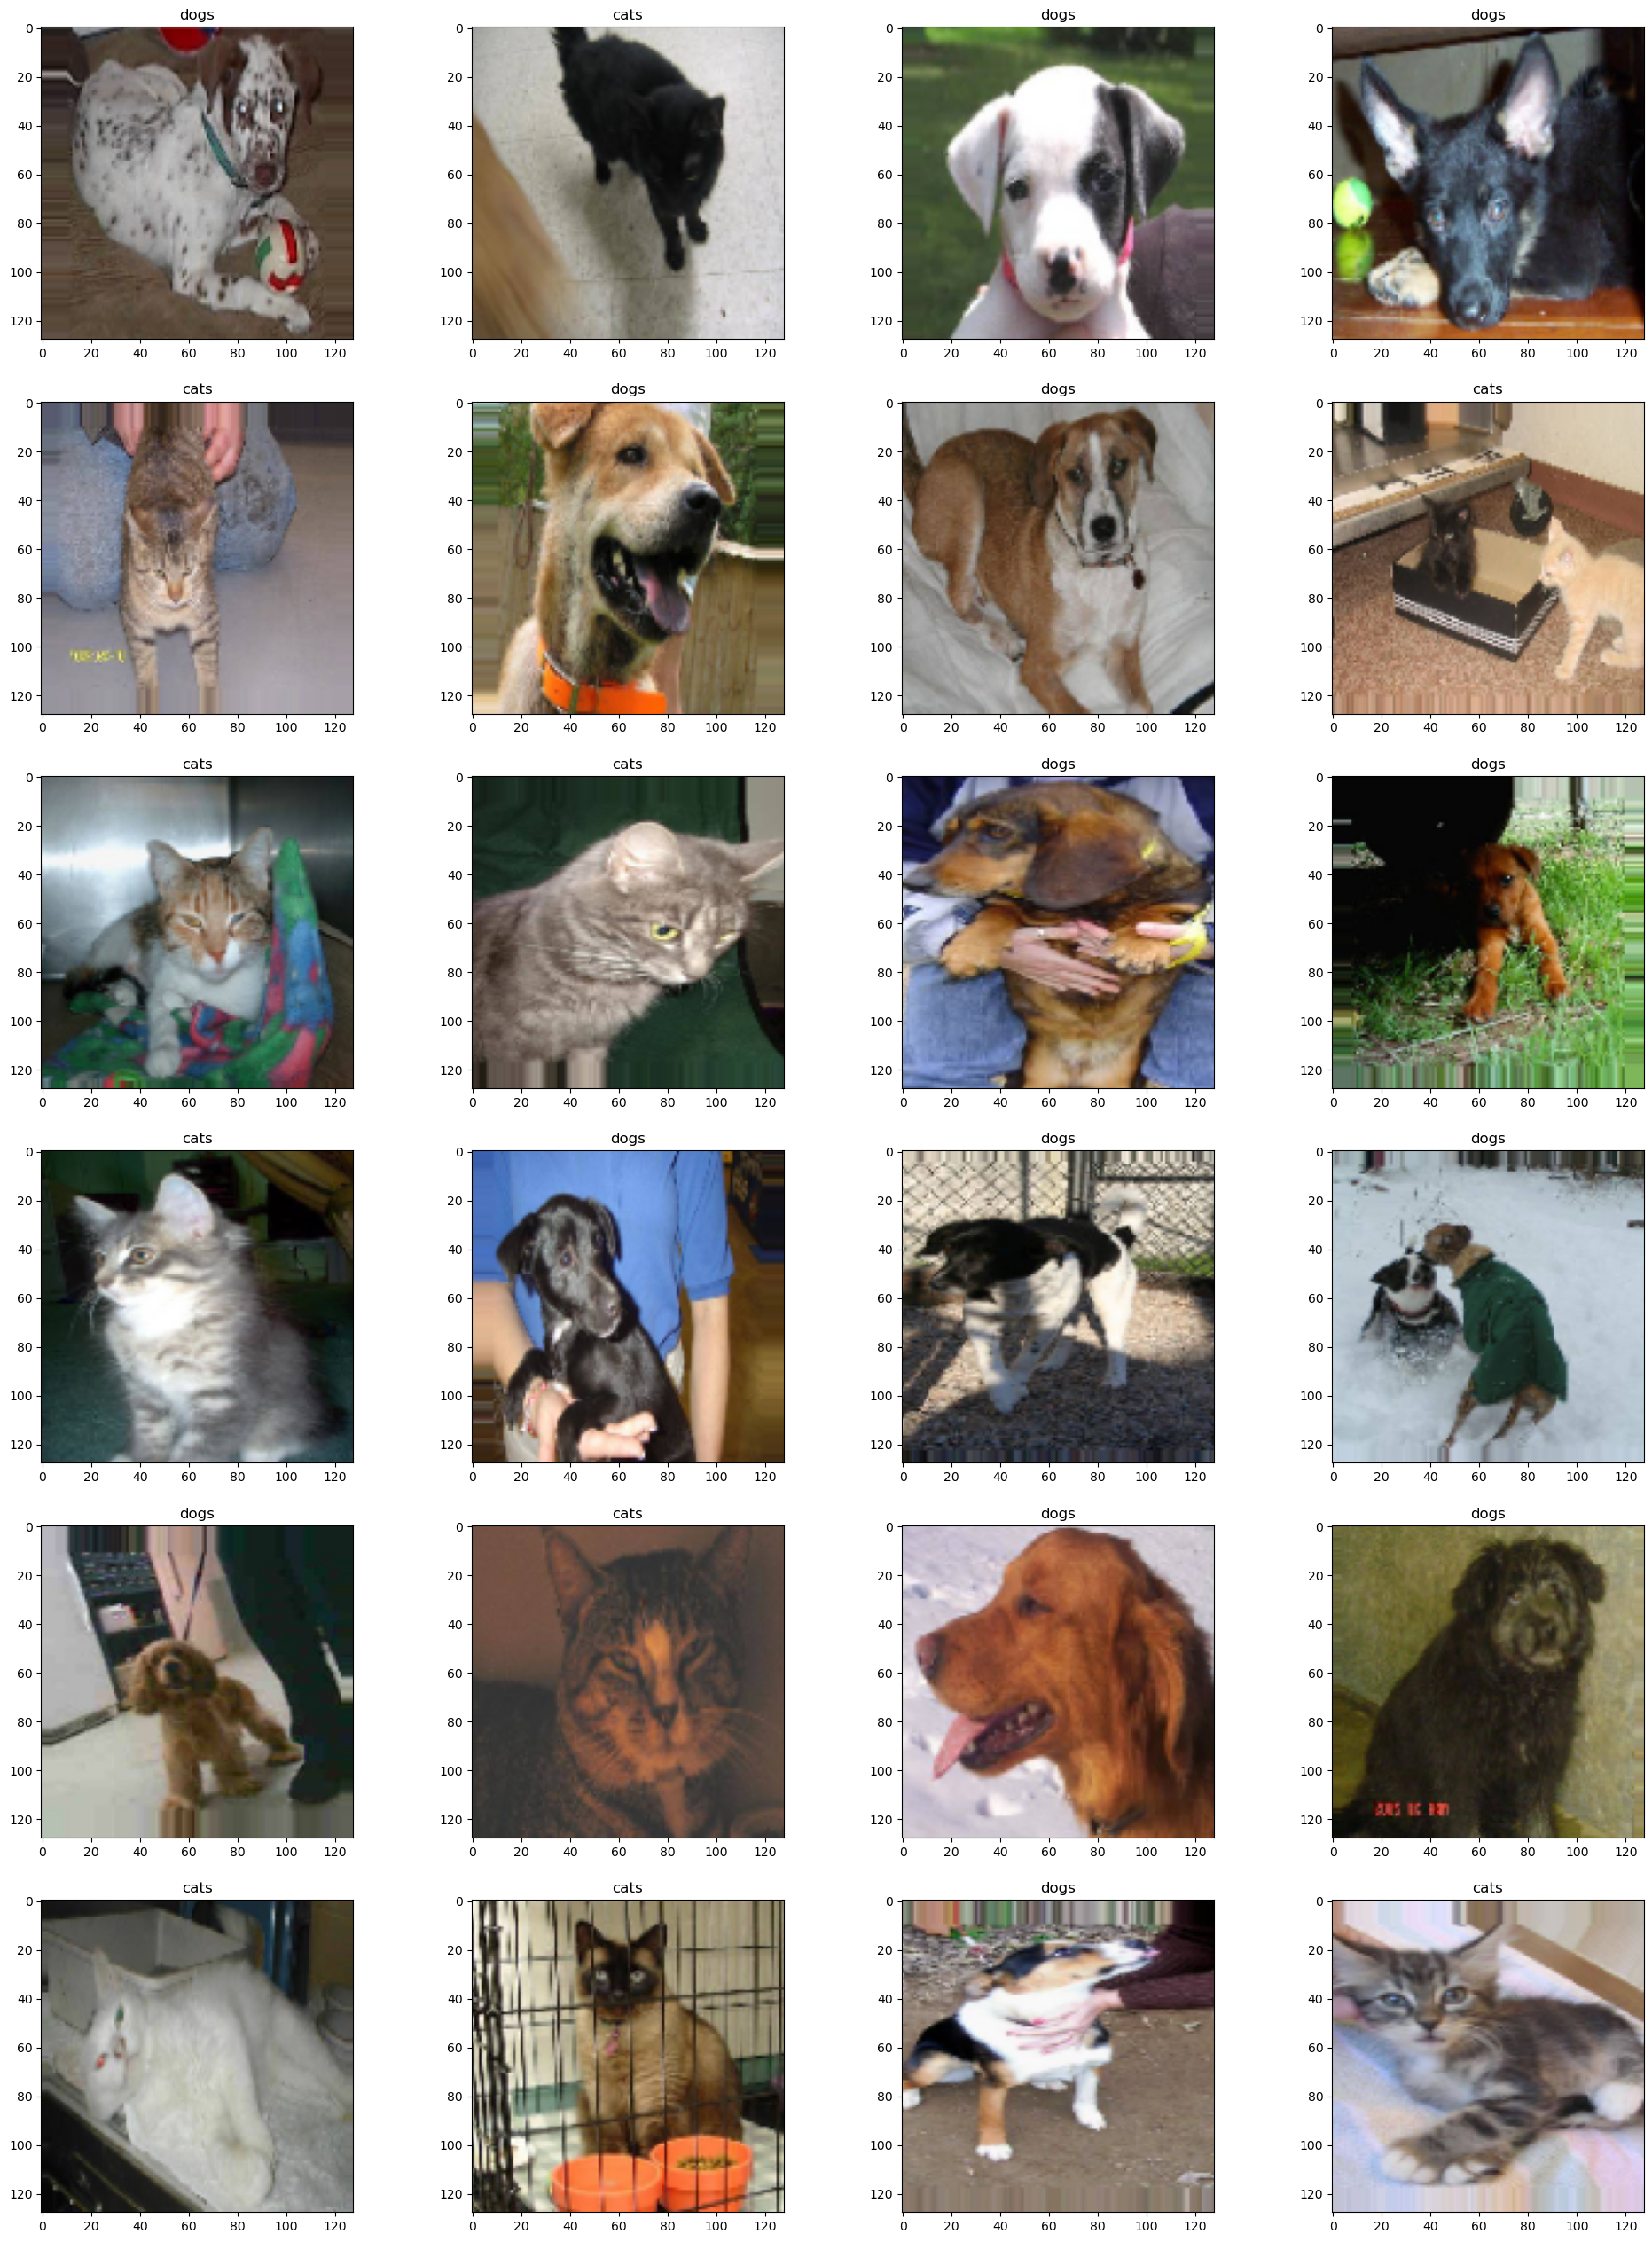

In [12]:
#Randomly visualizing an image from the training set
a=train_set.class_indices
classes=list(a.keys())
x,y=next(train_set)
plt.figure(figsize=[24,32])
for i in range(0,24):
    plt.subplot(6,4,i+1)
    plt.imshow(x[i])
    plt.title(classes[int(y[i])]) #Binary Classifier
    #plt.title(classes[np.argmax(y[i])]) #Multi Classifier

In [13]:
ss_train=train_set.n//train_set.batch_size
ss_test=test_set.n//test_set.batch_size
#call=tf.keras.callbacks.ModelCheckpoint('./CNN_Transfer_Model.hdf5',save_best_only=True,save_weights_only=False,mode='min')
call=EarlyStopping(patience=2,monitor='val_loss', mode='min', verbose=1,restore_best_weights=True)
#call=tf.keras.callbacks.EarlyStopping(patience=15,min_delta=0.001,mode='min',restore_best_weights=True)

In [14]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_203 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 64)                98368     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [15]:
#This generator will fit the CNN on the training set and evaluate its performance in the test set
#Without doing a optimization analysis of the code the accuracy from the training set is 0.9449 and test set 0.9567
classifier.fit(train_set,
                steps_per_epoch=ss_train,
                epochs=12,
                validation_data=test_set,
                validation_steps=ss_test,
                callbacks=[call])

Epoch 1/12
227/227 [==============================] - 499s 2s/step - loss: 0.1749 - accuracy: 0.9256 - val_loss: 0.1229 - val_accuracy: 0.9496
Epoch 2/12
227/227 [==============================] - 476s 2s/step - loss: 0.1436 - accuracy: 0.9351 - val_loss: 0.1075 - val_accuracy: 0.9531
Epoch 3/12
227/227 [==============================] - 472s 2s/step - loss: 0.1318 - accuracy: 0.9449 - val_loss: 0.1005 - val_accuracy: 0.9567
Epoch 4/12
227/227 [==============================] - 470s 2s/step - loss: 0.1226 - accuracy: 0.9492 - val_loss: 0.1142 - val_accuracy: 0.9546
Epoch 5/12
227/227 [==============================] - 479s 2s/step - loss: 0.1165 - accuracy: 0.9515 - val_loss: 0.1021 - val_accuracy: 0.9546
Epoch 5: early stopping


In [16]:
classifier.evaluate(test_set)

63/63 [==============================] - 98s 2s/step - loss: 0.1010 - accuracy: 0.9565


[0.1010017842054367, 0.9564999938011169]

In [17]:
path_dog='C://Users//####//Desktop//Computer_Vision//dataset//test_set//dogs'
path_cat='C://Users//####//Desktop//Computer_Vision//dataset//test_set//cats'
def list_data(path,label):
    im_list=[each for each in os.listdir(path) if each.endswith('.jpg')]
    im_list=pd.DataFrame(im_list,columns=['fname'])
    im_list['path']=path+'//'
    im_list['label']=label
    #im_list['fname']=pd.Series(im_list['fname'].str.replace('.jpg',''))
    return im_list
im_list_dog=list_data(path_dog,'dog')
im_list_cat=list_data(path_cat,'cat')
im_list=pd.concat([im_list_dog,im_list_cat],axis=0).reset_index(drop=True)

In [18]:
def eval_pred(args):
    fname,image_path,res_y=args
    image=cv2.imread(image_path+fname)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=image/255 #Only use if re-scaling
    image=cv2.resize(image,[ts,ts])
    image=np.expand_dims(image,axis=0)
    res_p=classifier.predict(image)
    res_x=np.where(res_p[0][0]>=0.5,'dog','cat')
    return res_x,res_y

In [19]:
%%time
pool=ThreadPool(processes=4)
res=pool.map(eval_pred,im_list.values)

1/1 [==============================] - 0s 212ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 342ms/step


1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 417ms/step


1/1 [==============================] - 0s 322ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 477ms/step


1/1 [==============================] - 0s 401ms/step


1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 400ms/step


1/1 [==============================] - 0s 156ms/step
Wall time: 4min 48s


In [20]:
res=pd.DataFrame(res)
y_res=np.where(res[1]=='dog',1,0)
x_res=np.where(res[0]=='dog',1,0)

Text(0.5, 1.0, 'Confusion Matrix Test')

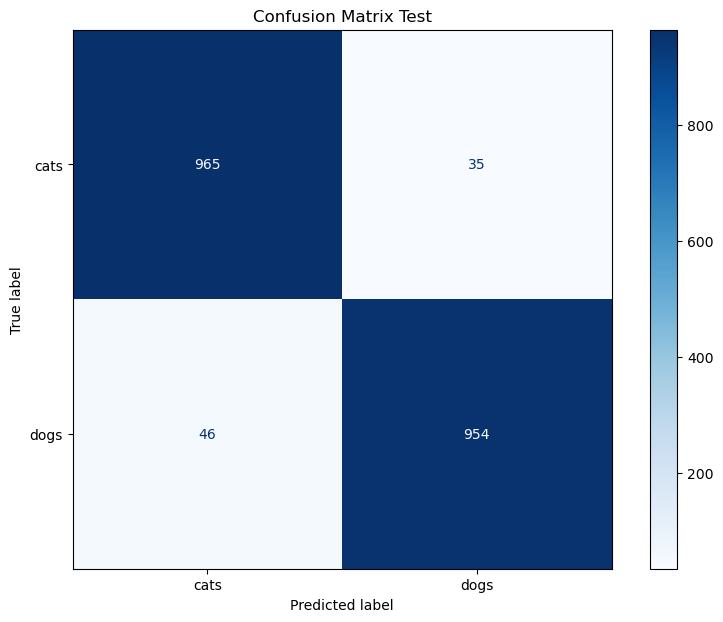

In [21]:
#Displaying confusion matrix of the validation data
plt.rcParams['figure.figsize']=[10,7]
a=train_set.class_indices
cm=confusion_matrix(np.array(y_res),np.array(x_res))
CMD=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=a)
CMD.plot(cmap='Blues',values_format='.0f')
plt.title('Confusion Matrix Test')

In [22]:
#Running classification report
print(classification_report(y_res,x_res,target_names=a))

              precision    recall  f1-score   support

        cats       0.95      0.96      0.96      1000
        dogs       0.96      0.95      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [23]:
#Binary breakdown
train_set.class_indices

{'cats': 0, 'dogs': 1}

In [24]:
path_pred='C://Users//####//Desktop//Computer_Vision//dataset//single_prediction'
im_list_pred=list_data(path_pred,'all')

In [25]:
%%time
pool=ThreadPool(processes=4)
res_pred=pool.map(eval_pred,im_list_pred.values)

1/1 [==============================] - 0s 317ms/step
Wall time: 1.97 s


In [26]:
res_pred=pd.DataFrame(res_pred)
predictions=np.where(res_pred[0]=='dog',1,0)

In [27]:
#Result of image predictions. #These images will be independent from both sets
#The predictor correctly determined 12 of 13 images. That is a 92.3% accuracy. 
image_results=pd.DataFrame([0,0,0,0,1,0,0,0,1,1,1,1,1],columns=['Actual'])
predictions=pd.DataFrame(predictions,columns=['Predictive'])

Text(0.5, 1.0, 'Confusion Matrix Holdout')

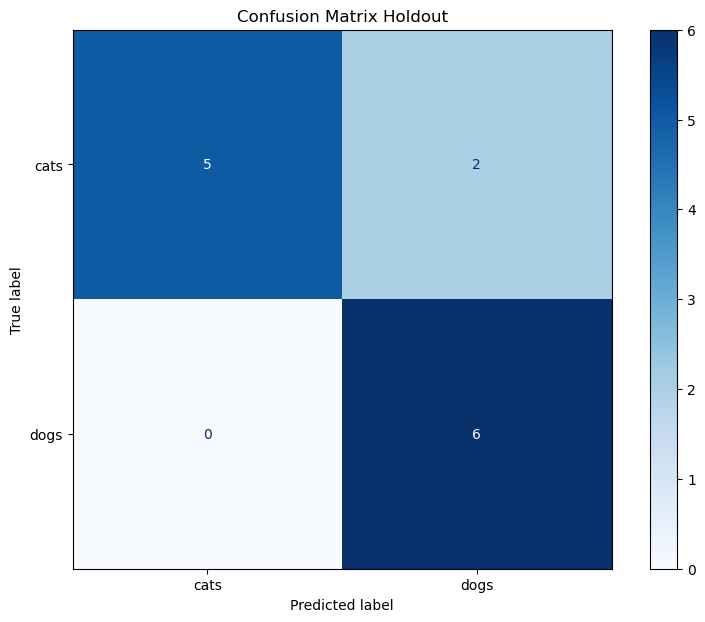

In [28]:
#Displaying confusion matrix of the validation data
plt.rcParams['figure.figsize']=[10,7]
a=train_set.class_indices
cm=confusion_matrix(np.array(image_results),np.array(predictions))
CMD=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=a)
CMD.plot(cmap='Blues',values_format='.0f')
plt.title('Confusion Matrix Holdout')

In [29]:
#Running classification report
print(classification_report(image_results,predictions,target_names=a))

              precision    recall  f1-score   support

        cats       1.00      0.71      0.83         7
        dogs       0.75      1.00      0.86         6

    accuracy                           0.85        13
   macro avg       0.88      0.86      0.85        13
weighted avg       0.88      0.85      0.84        13

